# 모듈 임포트

In [ ]:
!pip install torchinfo

In [ ]:
import os
import random

import numpy as np
import torch
from torch import nn

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from torchinfo import summary

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.1.0+cu118'

In [ ]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )


# 글로벌 변수 선언

In [ ]:
import easydict
args = easydict.EasyDict()
args.device = "cuda" if torch.cuda.is_available() else "cpu"

args.NUM_EPOCHS = 30
args.NUM_TRIALS = 5
args.BATCH_SIZE = 32

args.best_fine_tuning_model = 'best_fine_tuning_model.pt'


# 데이터 로드

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # data/pizza_steak_sushi

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)


data/pizza_steak_sushi directory exists.


In [ ]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 525 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 504 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 546 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## EDA

### PIL

Random image path: data/pizza_steak_sushi/train/pizza/2228322_rotate_rotate.jpg
Image class: pizza
Image height: 512
Image width: 512


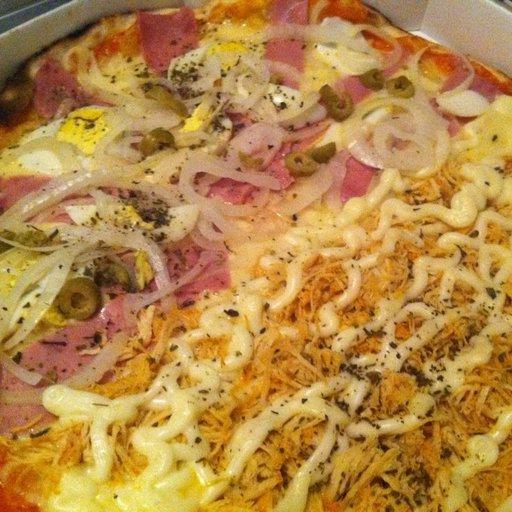

In [ ]:
import random
from PIL import Image

# Set seed
reset_seeds()

# 1. 모든 폴더에 있는 모든 jpg 조회
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. 랜덤하게 이미지 가져옴
random_image_path = random.choice(image_path_list)
# choices -> 복원 추출
# choice -> 비복원 추출

# 3. 랜덤 추출된 jpg 파일의 부모 폴더를 class로 지정 (pizza/steak/sushi)
image_class = random_image_path.parent.stem

# 4. 랜덤 이미지 추
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img


### matplotlib

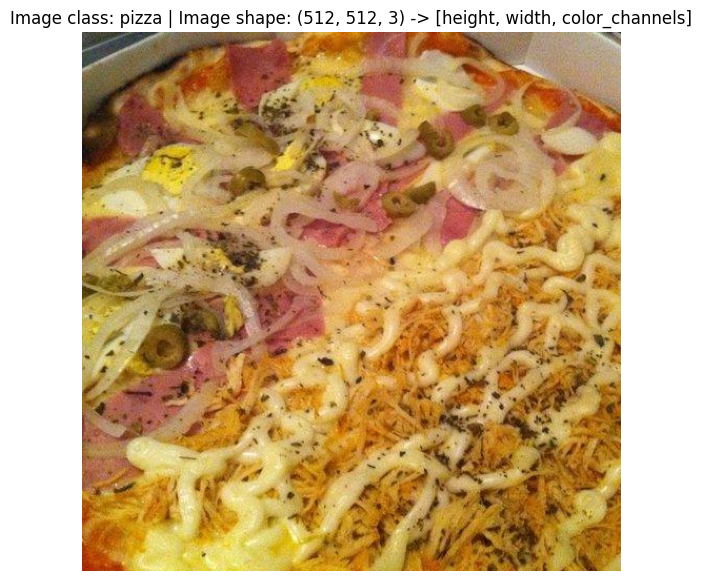

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Data Augmentation(옵션)

In [ ]:
# 학습용 전체 데이터들....
train_dir_list = list(train_dir.glob("*/*.jpg"))
print(f'데이터 증강전: {len(train_dir_list)}')


데이터 증강전: 1575


In [ ]:
for im_path in train_dir_list:
  _im = Image.open(im_path) # 원본 이미지 로드...
  _im_name = str(im_path).split(".")[0] # 원본 이미지 이름..

  # 상하반전... 저장
  _im.rotate(180).save(_im_name+"_rotate.jpg")
  # 좌우반전... 저장
  _im.transpose(Image.FLIP_LEFT_RIGHT).save(_im_name+"_transpose.jpg")


In [ ]:
# 학습용 전체 데이터들....
train_dir_list = list(train_dir.glob("*/*.jpg"))
print(f'데이터 증강후: {len(train_dir_list)}')


데이터 증강후: 3375


# Dataset

## Data Augmentation of Pretrained Model

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Dataset Class

In [ ]:
from typing import Tuple, Dict, List

# Make function to find classes in target directory
def find_classes(directory):
    # 1. Get the class names by scanning the target directory
    # classes -> ['pizza', 'steak', 'sushi']
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())


    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    # class_to_idx -> classes to 숫자(인덱스)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
classes, class_to_idx = find_classes(train_dir)
classes, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
import pathlib

# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)


In [ ]:
reset_seeds()

train_dataset = ImageFolderCustom(targ_dir=train_dir,
                                      transform=auto_transforms)
test_dataset = ImageFolderCustom(targ_dir=test_dir,
                                     transform=auto_transforms)

len(train_dataset), len(test_dataset)

(3375, 75)

# DataLoader

In [ ]:
reset_seeds()

train_dataloader = DataLoader(train_dataset,
                                        batch_size=args.BATCH_SIZE,
                                        shuffle=True)
test_dataloader = DataLoader(test_dataset,
                                    batch_size=args.BATCH_SIZE,
                                    shuffle=True)

len(train_dataloader), len(test_dataloader)

(106, 3)

# Model

- [오류 해결 방법](https://github.com/pytorch/vision/issues/7744)
> `RuntimeError: invalid hash value (expected "3dd342df", got "7f5810bc96def8f7552d5b7e68d53c4786f81167d28291b21c0d90e1fca14934")`

In [ ]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict


## Model with Pretrained Weight

In [ ]:
reset_seeds()

# 사전학습(pre-training) 모델 인스턴스 생성
model = torchvision.models.efficientnet_b0(weights=weights).to(args.device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## Fine Tuning

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
reset_seeds()

output_shape = len(train_dataset.classes)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(args.device)


In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 학습

## Engine

### train step

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(args.device), y.to(args.device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


### test step

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(args.device), y.to(args.device) # X (), y ()

            # 1. Forward pass
            test_pred_logits = model(X) # pred ()

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1) # pred_labes ()
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


### early stopping

In [ ]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_loss = np.inf
        self.save_path = save_path

    def is_continuable(self, model, loss):
        if loss < self.best_loss: # 현재 loss가 최고 loss보다 더 낮은 경우
            self.best_loss = loss # 최고 loss를 현재 loss로 업데이트
            self.trial_counter = 0 # 초기화
            torch.save(model, self.save_path) # 최고 loss를 갖은 모델 저장
            return True
        elif self.trial_counter + 1 < self.num_trials: # 현재 loss가 최고 loss보다 작은 경우 & max 시도횟수보다 현재 시도횟수가 작은 경우
            self.trial_counter += 1 # 기존 시도횟수 + 1
            return True
        else: # 현재 정확도가 최고 정확도보다 작은 경우 & 현재 시도횟수가 max 시도횟수보다 큰 경우
            return False

    def get_best_model(self, device=args.device):
        return torch.load(self.save_path).to(device)


## Training(학습!!)

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def main(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          early_stopper,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # 6. early stopper
        if not early_stopper.is_continuable(model, test_loss):
            print(f'validation: best loss: {early_stopper.best_loss}')
            break

    # 7. Return the filled results at the end of the epochs
    return results


In [ ]:
# Set random seeds
reset_seeds()

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

early_stopper = EarlyStopper(num_trials=args.NUM_TRIALS, save_path=args.best_fine_tuning_model)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train
fine_tuning_result = main(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        early_stopper=early_stopper,
                        loss_fn=loss_fn,
                        epochs=args.NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5071 | train_acc: 0.8599 | test_loss: 0.3275 | test_acc: 0.9271
Epoch: 2 | train_loss: 0.2250 | train_acc: 0.9508 | test_loss: 0.2606 | test_acc: 0.9167
Epoch: 3 | train_loss: 0.1568 | train_acc: 0.9661 | test_loss: 0.2948 | test_acc: 0.8665
Epoch: 4 | train_loss: 0.1149 | train_acc: 0.9770 | test_loss: 0.2427 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.1011 | train_acc: 0.9779 | test_loss: 0.2653 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.0834 | train_acc: 0.9841 | test_loss: 0.3141 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.0712 | train_acc: 0.9891 | test_loss: 0.2331 | test_acc: 0.9062
Epoch: 8 | train_loss: 0.0703 | train_acc: 0.9885 | test_loss: 0.2393 | test_acc: 0.9167
Epoch: 9 | train_loss: 0.0656 | train_acc: 0.9873 | test_loss: 0.2501 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.0602 | train_acc: 0.9884 | test_loss: 0.2687 | test_acc: 0.8968
Epoch: 11 | train_loss: 0.0522 | train_acc: 0.9884 | test_loss: 0.2652 | test_acc: 0.8968
Epoch: 12 | train_l

### loss 그래프

In [ ]:
def plot_loss_curves(results):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

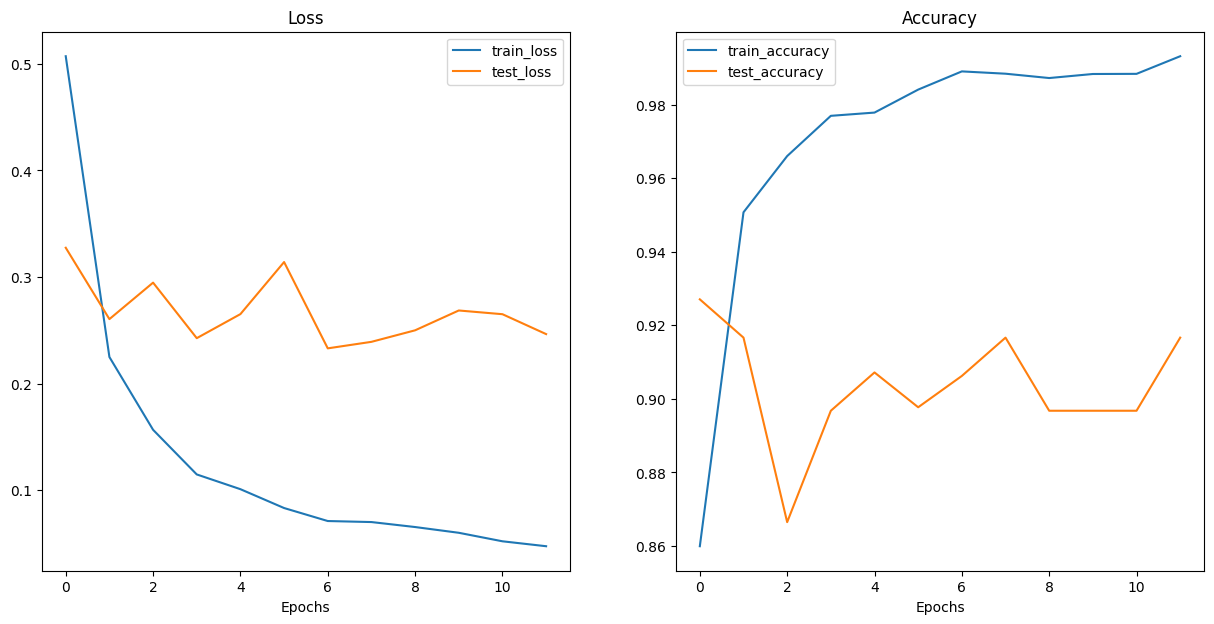

In [ ]:
plot_loss_curves(fine_tuning_result)

## Best Model

In [ ]:
best_model =  early_stopper.get_best_model(device=args.device)


### Test Score

In [ ]:
reset_seeds()

y_preds = []
targets = []
test_acc = 0

best_model.eval()

with torch.inference_mode():
  for batch, (X, y) in enumerate(test_dataloader):
    # Send data and targets to target device
    X, y = X.to(args.device), y.to(args.device)
    # Do the forward pass
    test_pred_logits = best_model(X)

    y_pred_class = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
    test_acc += (y_pred_class == y).sum().item()/len(test_pred_logits)

    # Put predictions on CPU for evaluation
    y_preds.append(y_pred_class.cpu())
    targets.append(y.cpu())

test_acc = test_acc / len(test_dataloader)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
targets_tensor = torch.cat(targets)

In [ ]:
print(f'best model에 대한 정확도: {test_acc}')

best model에 대한 정확도: 0.8465909090909092


### Confusion Matrix

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.0


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

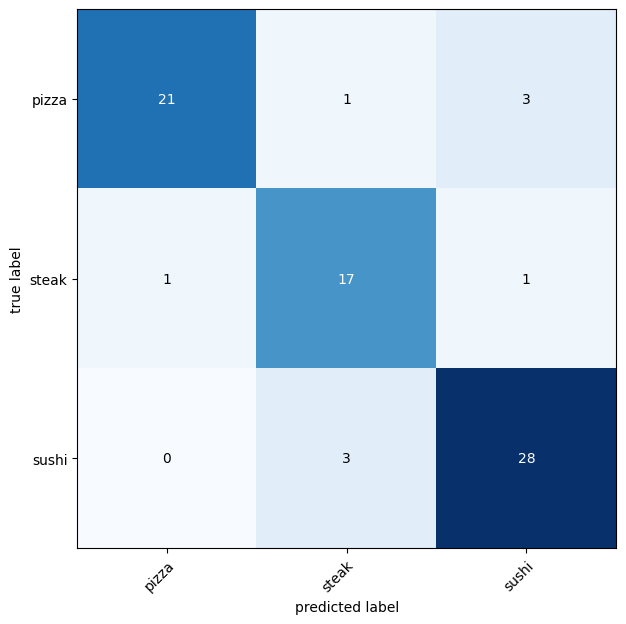

In [ ]:
reset_seeds()

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=targets_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

# Predictions with Best Model

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        transform: torchvision.transforms,
                        image_size: Tuple[int, int] = (224, 224),
                        device: torch.device="cpu"):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

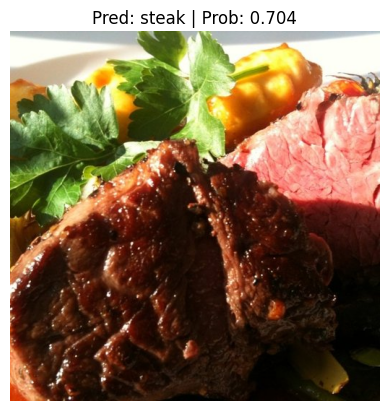

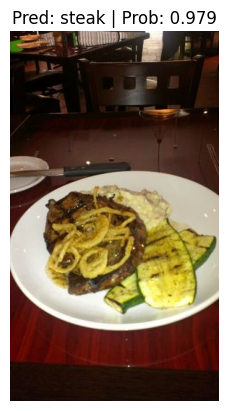

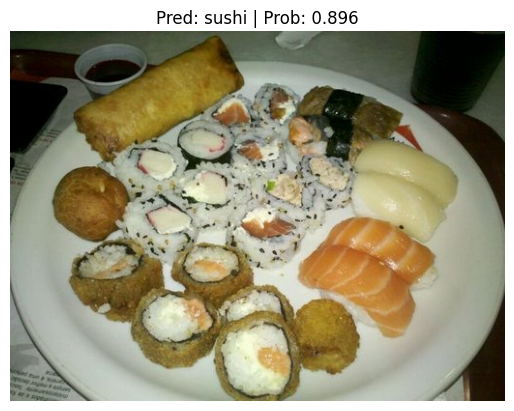

In [ ]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224),
                        device=args.device)